# Standard Hopfield Networks
References: 
* https://towardsdatascience.com/hopfield-networks-are-useless-heres-why-you-should-learn-them-f0930ebeadcd
* https://github.com/philipjk/genetic_algorithm_optimization_sklearn-based/blob/master/hopfield_networks.ipynb
* https://ml-jku.github.io/hopfield-layers/
* https://www.kaggle.com/kostastokis/simpsons-faces

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Utility function to generate random patterns to put on test the pattern retrieval

In [2]:
def generate_paterns(n=1, x=64, y=64):
    res = []
    fig, ax = plt.subplots(1, n, figsize=(18, 6))
    try:
        axes = ax.ravel()
    except:
        axes = []
        axes.append(ax)
    for i in range(n):
        im = -np.ones((x, y))
        # Randomly select a box in the image
        im[np.random.randint(0, y / 2):np.random.randint(x/2, y),
           np.random.randint(0, y/2):np.random.randint(x/2, y)] = 1
        axes[i].imshow(im, cmap='binary')
        axes[i].set_title(f"pattern #{i}")
        im = np.reshape(im, (x * y))
        res.append(im)
    return np.array(res).T

### Define the Hopfield Energy Function
This is the hopfield energy that we expect to minimize. This is equivalent to:
$$
\begin{gather}
E = -\frac{1}{2}\sum_{i}\sum_{j}w_{ij}\xi_i\xi_j + \sum_{i=1}^db_i\xi_i \\
= -\frac{1}{2}\xi^TW\xi + b^TW
\end{gather}
$$

Where $\xi$ is the state pattern, $W$ is the weight matrix that stores the patterns, and $b$ is a bias vector.

In this notebook, the example does not use a bias term, so we drop it and the formulas are reduced to:
$$
\begin{gather}
E = -\frac{1}{2}\sum_{i}\sum_{j}w_{ij}\xi_i\xi_j \\
= -\frac{1}{2}\xi^TW\xi
\end{gather}
$$

In [3]:
def energy(state, W):
    """Hopfield Energy
    This is equivalent to the second equation from the previous block.
    """
    return -0.5 * state.T @ W @ state

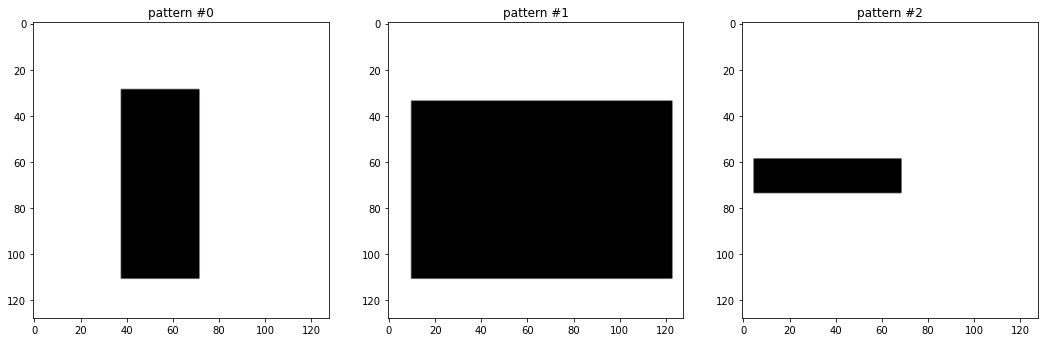

In [4]:
patterns = 3
width = 128
height = 128
X = generate_paterns(patterns, width, height)

### Build the weight matrix
Let $c$ be the "learning rate". In classic Hopfield Networks, the corresponding $W$ matrix is:
$$
W = \sum_{i}^N x_i x_i^T

= XX^T
$$

The $W$ matrix store patterns, which can be retrieved from a **state pattern** $\xi$, i.e., by multiplying $\xi$ by $W$ several times we could retrieve the original pattern.

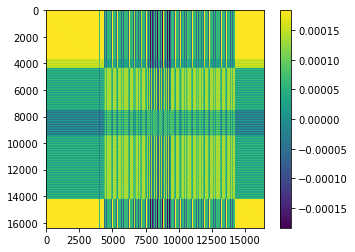

In [5]:
c = 1
W = c * (1 / (width * height)) * (X @ X.T)
# Zero diagional
np.fill_diagonal(W, 0)
plt.imshow(W)
plt.colorbar()
plt.show()

### Get a corrupted pattern
Select a random pattern from the examples and corrupt it with Gaussian noise.

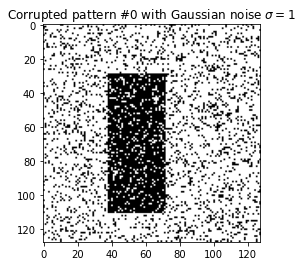

In [6]:
which = np.random.randint(0, patterns)
sigma = 1
et = X[:, which] + sigma * np.random.randn((width * height))
et[et > 0] = 1
et[et < 0] = -1

plt.imshow(np.reshape(et, (width, height)), cmap='binary')
plt.title(f"Corrupted pattern #{which} with Gaussian noise $\sigma={sigma}$")
plt.show()

## Reconstruct from corrupted pattern - The update Rule
The idea is to perform iteratively a matrix multiplication of the corrupted pattern with the Weight Matrix and calculate the energy generated by the result. We will repeat this process till we get no change from the energy of the new pattern or if we exhausted a predefined number of iterations.

### The Syncrhonous update rule
The sync update rule is to repeatedly multiply the state patter $\xi$ with the weight matrix $W$, substract the bias and take the sign:
$$
\xi^{t+1}=sgn(W\xi^t-b)
$$

For the example elaborated in this notebook, the bias term is dropped for simplicity, hence we can define the new state pattern as:
$$
\xi^{t+1}=sgn(W\xi^t)
$$

### The Asynchronous update rule
The async update rule performs this update only for one component of $\xi$ and then selects the next component for update. i.e., it updates one element of $\xi$ at the time while performing the same operation above. Convergence is reached if $\xi^{t+1} = \xi^t$. The asynchronous version of the update rule from above minimizes the energy function E:
$$
E = -\frac{1}{2}\xi^TW\xi+\xi^Tb
= -\frac{1}{2}\sum_{i=1}^{d}\sum_{j=1}^{d}w_{ij}\xi_i\xi_j+\sum_{i=1}^db_i\xi_i
$$

### Stable state
When $E = (\xi^{t+1}) = E = (\xi^{t})$ it is said that a local minima in $E$ has been reached, the network is stable and all stored patterns $\{x_i\}_{i=1}^N$ should be fixed points of the Hopfield network, i.e.,
$$
x_i = sgn(Wx_i -b)
$$

In [7]:
def retrieve_pattern(et, W, sync_update: bool = False, steps: int = 200):
    evolution = []
    energy_history = []
    energy_old = np.infty
    energy_new = energy(et, W)
    iteration = 0

    while (energy_old > energy_new) and iteration < steps:
        iteration += 1
        energy_old = energy_new
        evolution.append(np.copy(et))
        energy_history.append(energy_old)

        # synchronous update, i.e., full
        if sync_update:
            et = np.sign(W @ et)
        else:
        # asynchronous update
            for pixel in np.split(np.random.randint(0,len(et),width*height), 8):
                et[pixel] = np.sign(W[pixel,:] @ et)
        
        energy_new = energy(et, W)

    print(f"Stopped at iteration {iteration}")
    return et, evolution, energy_history

e_final, evolution, energy_history = retrieve_pattern(et, W) 

Stopped at iteration 9


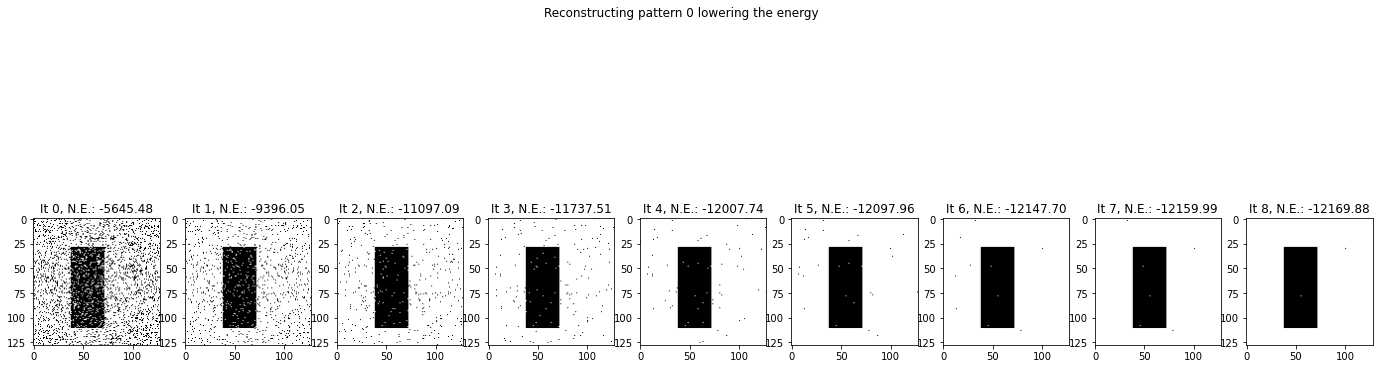

In [8]:
show_every = 1
fig, ax = plt.subplots(1, int(len(evolution) / show_every), figsize=(24, 8))
axes = ax.ravel()
fig.suptitle(f"Reconstructing pattern {which} lowering the energy")
plot_idx = 0
for idx in range(len(evolution)):
    if (idx % show_every) == 0:
        axes[plot_idx].imshow(np.reshape(evolution[idx], (width, height)), cmap='binary')
        axes[plot_idx].set_title(f"It {idx}, N.E.: {energy_history[idx]:.2f}")
        plot_idx += 1

plt.show()

Here we can observe how after the ninth iteration the original pattern was recovered. Furthermore, we observe how the energy decreases on each iteration, meaning the state pattern stabilizes.

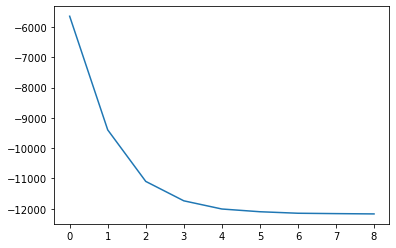

In [9]:
plt.plot(energy_history)
plt.show()

We can observe how the energy is reduced on each iteration and how the original pattern is retrieved.

### Other experiments
With the implementation above, we can use it to store other patterns, for example a Homer:

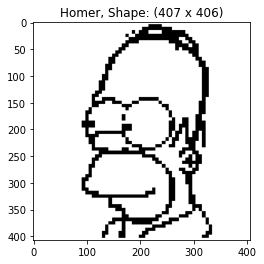

In [10]:
import matplotlib.pyplot as plt
from matplotlib import image

homer = image.imread('images/homer_bw.png')
plt.title(f"Homer, Shape: ({homer.shape[0]} x {homer.shape[1]})")
homer = homer[:,:,0] # The file has 4 channels, but we only need the first one as this is a black & white image
plt.imshow(homer, cmap='gray')
plt.show()

Once more, we need to define $W$, which as per the previous explanation, in this case it is defined as:
$$
W = x_{homer}x_{homer}^T
$$

##### Note:
The homer image is (407 x 406), in order to fit it to the hopfield energy we need to flatten this image to get the $W$ matrix. This is a large matrix to deal with, to ease the things a bit, let's resize the image to `128 x 128`.

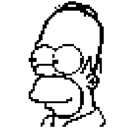

In [11]:
from PIL import Image

im = Image.open('images/homer_bw.png')
im.thumbnail([128, 128])
homer = np.array(im)
homer = homer[:, :, 0]
homer_v = homer.flatten()
homer_v = homer_v.reshape(homer_v.shape[0], 1)
im

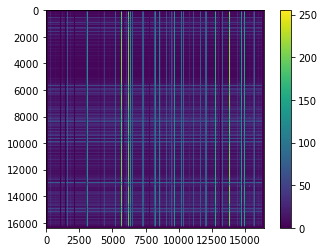

In [12]:
W = homer_v @ homer_v.T
plt.imshow(W)
plt.colorbar()
plt.show()

Now, the idea is to recover a corrupted or masked version of this pattern to put Hopfield to test.

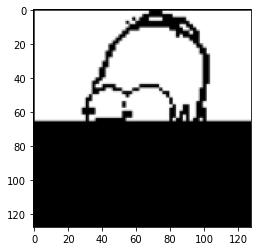

In [13]:
homer_masked = Image.open('images/homer_bw_masked.png')
homer_masked.thumbnail([128, 128])
homer_masked = np.array(homer_masked)
homer_masked = homer_masked[:,:,0]
plt.imshow(homer_masked, cmap='gray')
plt.show()

The above masked image is our initial state pattern $\xi$. This state will be multiplied with $W$ till we retrieve back the original pattern.

In [14]:
homer_retrieved, evolution, energy_history = retrieve_pattern(homer_masked.flatten(), W, sync_update=True)

Stopped at iteration 1


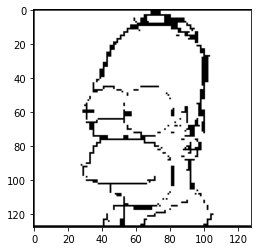

In [15]:
plt.imshow(homer_retrieved.reshape(128, 128), cmap='gray')
plt.show()

We observe the original pattern was retrieved after one iteration.

We can test for other examples:

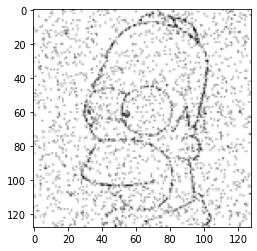

In [24]:
homer_noise = Image.open('images/homer_bw_noise.png')
homer_noise.thumbnail([128, 128])
homer_noise = np.array(homer_noise)
plt.imshow(homer_noise, cmap='gray')
plt.show()

Stopped at iteration 1


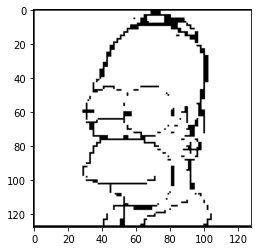

In [25]:
homer_retrieved, evolution, energy_history = retrieve_pattern(homer_noise.flatten(), W, sync_update=True)
plt.imshow(homer_retrieved.reshape(128, 128), cmap='gray')
plt.show()

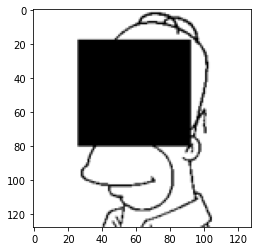

In [26]:
homer_masked = Image.open('images/homer_bw_rand_mask.png')
homer_masked.thumbnail([128, 128])
homer_masked = np.array(homer_masked)
plt.imshow(homer_masked, cmap='gray')
plt.show()

Stopped at iteration 1


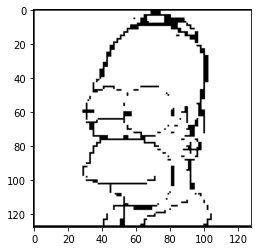

In [27]:
homer_retrieved, evolution, energy_history = retrieve_pattern(homer_masked.flatten(), W, sync_update=True)
plt.imshow(homer_retrieved.reshape(128, 128), cmap='gray')
plt.show()